In [39]:
import numpy as np
import geopandas
import rioxarray
import xarray as xr
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy.ma as ma
import datetime

In [40]:
dataset = xr.open_dataset("./italiaecmwf.nc", decode_coords="all")
shapefile = geopandas.read_file('./italy_shapefile/italy_shapefile.shp', crs="epsg:4326")
dataset

<xarray.Dataset>
Dimensions:    (longitude: 15, latitude: 15, time: 31)
Coordinates:
  * longitude  (longitude) float32 7.0 7.75 8.5 9.25 ... 15.25 16.0 16.75 17.5
  * latitude   (latitude) float32 46.5 45.75 45.0 44.25 ... 37.5 36.75 36.0
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-01-31
Data variables: (12/20)
    aod1240    (time, latitude, longitude) float32 ...
    aod469     (time, latitude, longitude) float32 ...
    aod550     (time, latitude, longitude) float32 ...
    aod670     (time, latitude, longitude) float32 ...
    aod865     (time, latitude, longitude) float32 ...
    tcco       (time, latitude, longitude) float32 ...
    ...         ...
    tc_no      (time, latitude, longitude) float32 ...
    gtco3      (time, latitude, longitude) float32 ...
    tc_pan     (time, latitude, longitude) float32 ...
    tc_c3h8    (time, latitude, longitude) float32 ...
    tcso2      (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-14 10:41:43 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [41]:
datarray_CO = dataset['tcco']
datarray_CO.rio.write_crs("epsg:4326", inplace=True)
clipped = datarray_CO.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)

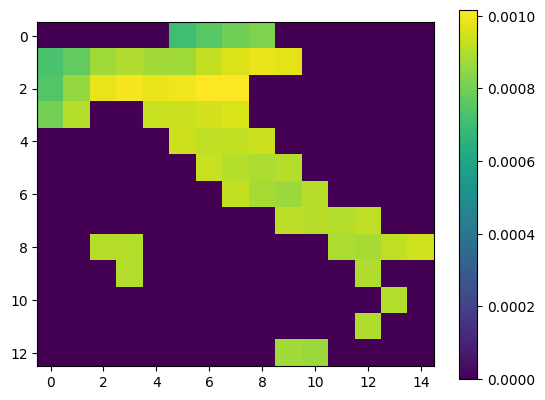

In [43]:
monthly_CO_Italy = clipped.resample(time="1MS", restore_coord_dims=True).sum(dim='time')/30
plt.imshow(monthly_CO_Italy[0])
plt.colorbar()

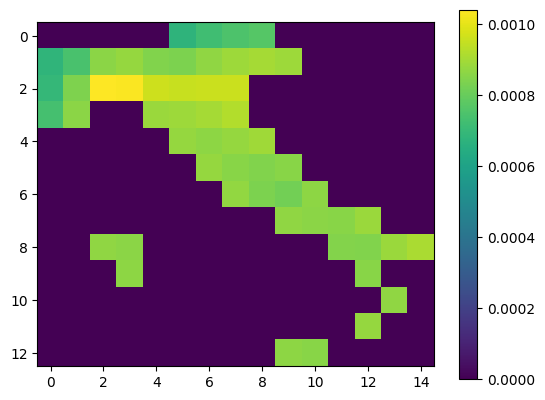

In [44]:
daily_CO_Italy = clipped.resample(time="1D", restore_coord_dims=True).sum(dim='time')
plt.imshow(daily_CO_Italy[0])
plt.colorbar()

In [45]:
daily_CO_Italy_vals = np.array(daily_CO_Italy)
italia=daily_CO_Italy_vals[daily_CO_Italy_vals!=0].size
vector=np.zeros([31,1])
j=0
while j<31:
    m=daily_CO_Italy_vals[j]
    vector[j]=sum(sum(m))/italia
    j=j+1

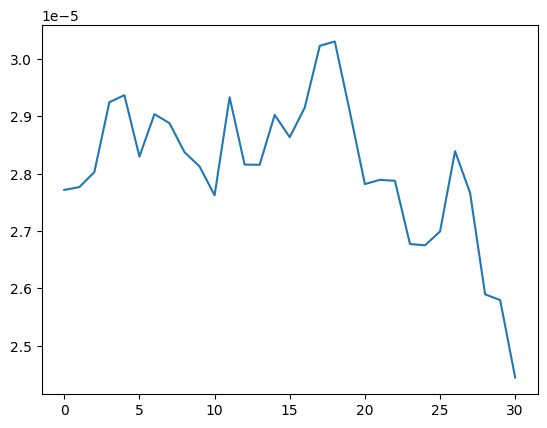

In [46]:
plt.plot(np.arange(0, 31), vector.reshape(-1))

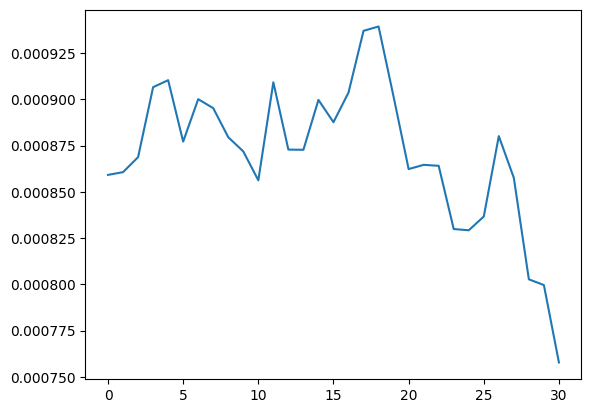

In [47]:
plt.plot(np.arange(0,31), daily_CO_Italy.where(daily_CO_Italy != 0).groupby("time").mean(dim=['longitude', 'latitude']).values)

In [ ]:
# Create some mock data
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (day)')
ax1.set_ylabel('CO [kg m-2]', color=color)
ax1.plot(time, vector, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('O3 [kg m-2]', color=color)  # we already handled the x-label with ax1
ax2.plot(time, vector_O3, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('NO2 [kg m-2]', color=color)  # we already handled the x-label with ax1
ax2.plot(time, vector_NO2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

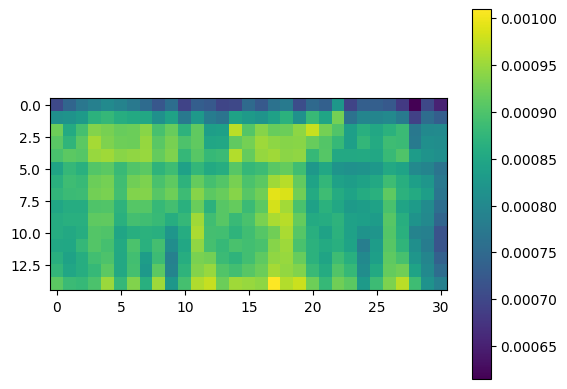

In [55]:
plt.imshow(clipped.groupby("time").mean(dim='latitude').T.values)
plt.colorbar()